In [1]:
import numpy as np
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from scipy import special
plt.rcParams['figure.figsize'] = [14, 11]

In [2]:
def Voigt(x, x0, sigma, gamma):
    '''
    x should be an array.
    sigma is the Doppler parameter.
    gamma is the Gaussian sigma.
    x0 is the center position.
    '''
    z = ((x-x0) + 1j * abs(gamma)) / abs(sigma) / 2**0.5

    return (special.wofz(z)).real/abs(sigma)/(2*np.pi)**0.5

def vline(x, p):
    '''
    p = [sigma, gamma, tau, v0, covering_factor]
    saturated_factor is a newly defined parameter to describe the thermal radiation varying in 0 to 1.
    The simplified model is c_f * exp(-tau) + (1-c_f).
    '''
    x = np.array(x)
    pro = abs(p[2]) * Voigt(x, p[3], p[0], abs(p[1]))

    return abs(p[4]) * np.exp(-pro) + (1 - abs(p[4]))

def convolve(model, lsf):
    Nlsf = len(lsf) // 2
    ext_model = np.append(np.ones(Nlsf)*model[0], model)
    ext_model = np.append(ext_model, np.ones(Nlsf)*model[-1])
    cmodel = np.convolve(ext_model, lsf, 'valid')
    return cmodel

def N2tau(N, wlr, f):
    tau = N * 2.654e-15 * f * wlr
    return tau

def model(p0):
    m1 = np.ones(v1.shape)
    m2 = np.ones(v2.shape)
    Ncomp = len(p0)//3
    for comp_i in range(Ncomp):
        N, b, vc = p0[comp_i*3: comp_i*3+3]
        m1 = m1*vline(v1, [b/1.414, gamma1, N2tau(10**N, wl1, f1), vc, 1])
        m2 = m2*vline(v2, [b/1.414, gamma2, N2tau(10**N, wl2, f2), vc, 1])

    m1 = convolve(m1, lsf)
    m2 = convolve(m2, lsf)

    return m1, m2

def fitting(p0):
    m1, m2 = model(p0)
    chi1 = (fn1 - m1) / fne1
    chi2 = (fn2 - m2) / fne2

    chi1 = chi1[(v1 < 200) & (v1 > -200)]
    chi2 = chi2[(v2 < 200) & (v2 > -200)]

    return np.append(chi1, chi2)

def plot_model(p0):
    m1, m2 = model(p0)
    plt.step(v1, fn1+1, 'k-', lw=2, where='mid')
    plt.plot(v1, m1+1, 'r--', lw=2)
    plt.hlines(1, -400, 400, linestyles='dashed', colors='c')
    plt.step(v2, fn2, 'k-', lw=2, where='mid')
    plt.plot(v2, m2, 'r--', lw=2)
    plt.hlines(2, -400, 400, linestyles='dashed', colors='c')

    Ncomp = len(p0)//3
    for comp_i in range(Ncomp):
        N, b, vc = p0[comp_i*3: comp_i*3+3]
        m1 = vline(v1, [b/1.414, gamma1, N2tau(10**N, wl1, f1), vc, 1])
        m2 = vline(v2, [b/1.414, gamma2, N2tau(10**N, wl2, f2), vc, 1])

        m1 = convolve(m1, lsf)
        m2 = convolve(m2, lsf)
        plt.plot(v1, m1+1, 'y:', lw=2)
        plt.plot(v2, m2, 'y:', lw=2)

    plt.xlim(-400, 400)
    plt.show()
    
def N_v(fn, wlr, f):
    return -np.log(fn)/wlr/f/2.654e-15

In [3]:
lsf = np.loadtxt('FAIRALL9/CIV.lsf')

v1, fl1, fe1, ctn1 = np.loadtxt('FAIRALL9/CIV1548.bin3.linespec').transpose()
fn1 = fl1 / ctn1
fne1 = fe1 / ctn1
v2, fl2, fe2, ctn2 = np.loadtxt('FAIRALL9/CIV1550.bin3.linespec').transpose()
fn2 = fl2 / ctn2
fne2 = fe2 / ctn2

wl1, f1, gamma1, elem, state = (1548.187, 0.19, 0.00324, 'C', 'IV')
wl2, f2, gamma2, elem, state = (1550.772, 0.0952, 0.00325, 'C', 'IV')

x0 = [13.5, 20.3, -20] + [13.5, 20.3, 40] + [13, 20.3, 150] + [13, 20.3, 170]
p0, cov, a, b, c = leastsq(fitting, x0, full_output=1)

In [4]:
def make_features(p0, v1, v2, gamma1, gamma2, lsf):
    length = len(p0) // 4
    Ns_tot = 0
    Nw_tot = 0 
    for i in range(length):
        Ns_tot += 10**(p0[3 * i])*Voigt(v1, p0[2 + 3*i], p0[1 + 3*i]/np.sqrt(2), gamma1)
        Nw_tot += 10**(p0[3 * i])*Voigt(v2, p0[2 + 3*i], p0[1 + 3*i]/np.sqrt(2), gamma2)
    Ns_c = convolve(Ns_tot, lsf)
    Nw_c = convolve(Nw_tot, lsf)
    return Ns_c, Nw_c

def add_residual(Ns_c, Nw_c, p0, wl1, wl2, f1, f2):
    m1, m2 = model(p0)
    r1 = fn1 / m1
    r2 = fn2 / m2
    N_r_s = N_v(r1, wl1, f1)
    N_r_w = N_v(r2, wl2, f2)
    Ns_c += N_r_s
    Nw_c += N_r_w
    return Ns_c, Nw_c

def plot_features(v1, v2, f1, f2, fe1, fe2):
    plt.plot(v1, f1, '-k', label='Strong')
    plt.plot(v2, f2, '-r', label='Weak')
    plt.plot(v1, fe1, '.b', label='Strong Error')
    plt.plot(v2, fe2, '.g', label='Weak Error')
    plt.title('Strong and Weak Figures Without Residual')
    plt.xlabel('Velocity [km/2]')
    plt.ylabel('Flux')
    plt.xlim(-300,300)
    plt.legend()
    plt.show()
    
def plot_features_no_show(v1, v2, f1, f2, fe1, fe2):
    plt.plot(v1, f1, '-k', label='Strong')
    plt.plot(v2, f2, '-r', label='Weak')
    plt.plot(v1, fe1, '.b', label='Strong Error')
    plt.plot(v2, fe2, '.g', label='Weak Error')
    plt.title('Strong and Weak Figures Without Residual')
    plt.xlabel('Velocity [km/2]')
    plt.ylabel('Flux')
    plt.xlim(-300,300)
    plt.legend()

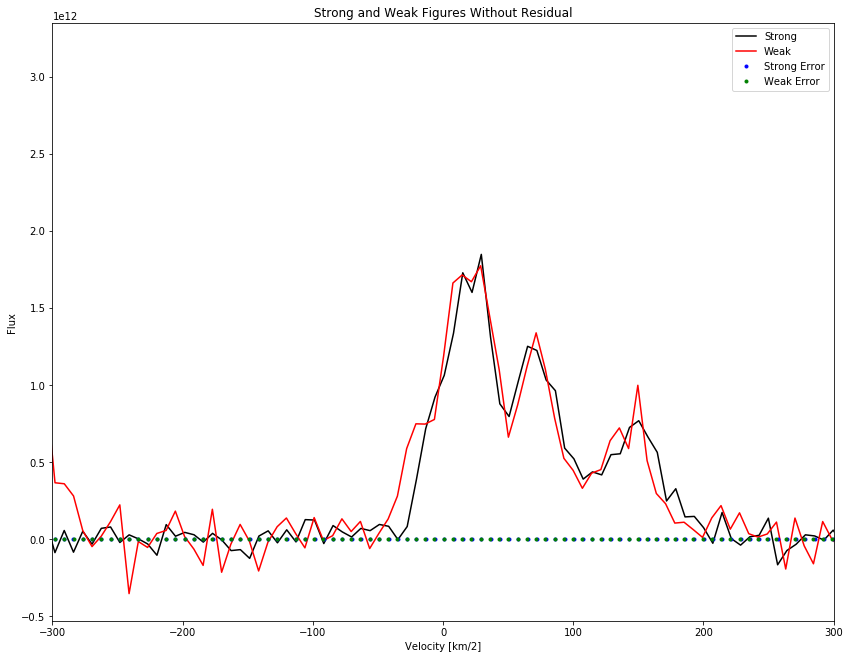

In [5]:
Ns, Nw = make_features(p0, v1, v2, gamma1, gamma2, lsf)
Ns_r, Nw_r = add_residual(Ns, Nw, p0, wl1, wl2, f1, f2)
#plot_features(v1, v2, Ns, Nw)
plot_features(v1, v2, Ns_r, Nw_r, fe1, fe2)

In [6]:
def make_same_length(a1, a2):
    while(len(a1) != len(a2)):
        if (len(a1) < len(a2)):
            l = a2.tolist()
            l.pop(-1)
            a2 = np.array(l)
        else :
            l = a1.tolist()
            l.pop(-1)
            a1 = np.array(l)
    return a1, a2

#Not done yet below

def combine_features(v1, v2, f1, f2, fe1, fe2):
    plot_features_no_show(v1, v2, f1, f2, fe1, fe2)
    v1, v2 = make_same_length(v1, v2)
    f1, f2 = make_same_length(f1, f2)
    fe1, fe2 = make_same_length(fe1, fe2)
    
    
    # need to turn the error in flux to the error in column density, and need a reminder on how to combine 
    # the data based off the value of the error.

    f_avg = (f1 + f2) / 2
    v_avg = (v1 + v2) / 2
    f_avg, v_avg = make_same_length(f_avg, v_avg)
    plt.plot(v_avg, f_avg, 'm-', label='Coadd Feature')
    plt.show()
    

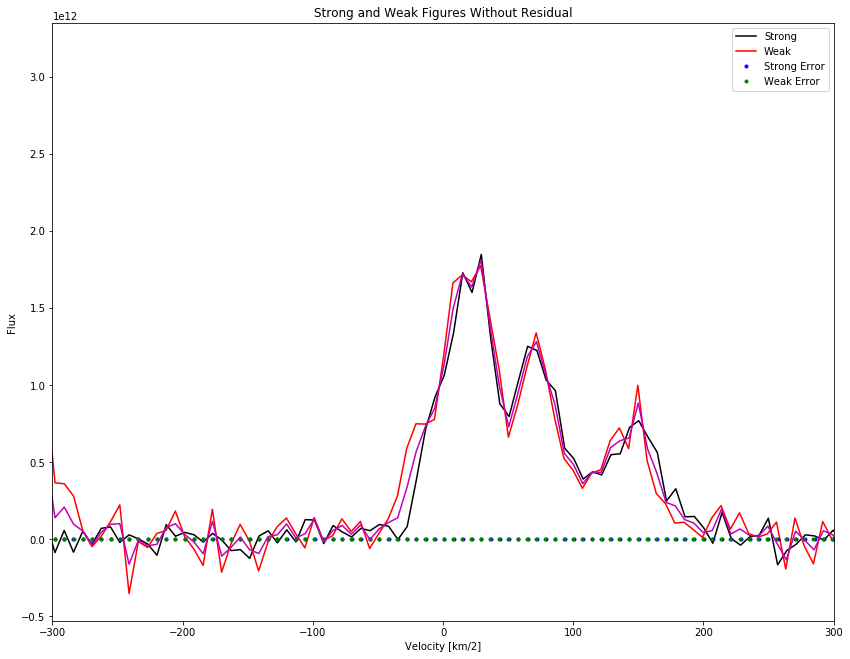

In [7]:
combine_features(v1, v2, Ns_r, Nw_r, fe1, fe2)